In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as sc
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from arch import arch_model

In [2]:
# 대충 한 10년간 데이터 불러들였습니다
msft_df = yf.download("MSFT", start = '2014-01-01',end='2024-05-18')

[*********************100%%**********************]  1 of 1 completed


In [3]:
msft_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,37.349998,37.400002,37.099998,37.160000,31.176830,30632200
2014-01-03,37.200001,37.220001,36.599998,36.910000,30.967073,31134800
2014-01-06,36.849998,36.889999,36.110001,36.130001,30.312672,43603700
2014-01-07,36.330002,36.490002,36.209999,36.410000,30.547585,35802800
2014-01-08,36.000000,36.139999,35.580002,35.759998,30.002241,59971700


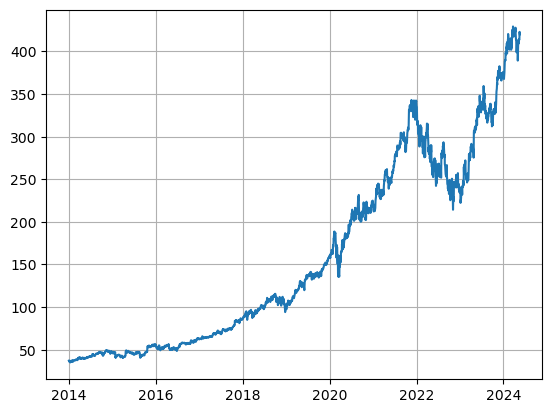

In [4]:
# 종가 시각화
plt.plot(msft_df['Close'])
plt.grid(True)
plt.show()

In [5]:
# 42일 이동평균, 52일 이동평균
msft_df['42d'] = np.round(msft_df['Close'].rolling(window=42).mean(),2)
msft_df['252d'] = np.round(msft_df['Close'].rolling(window=252).mean(),2)

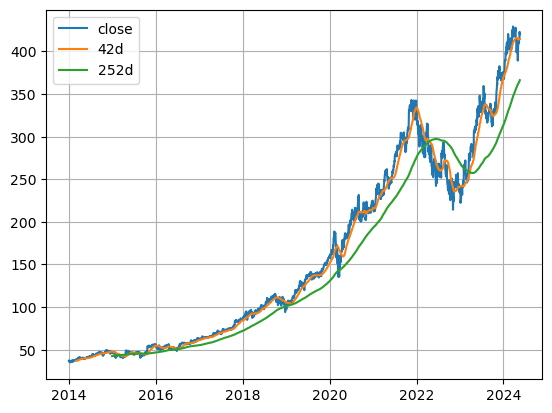

In [6]:
# 이평선(이동평균선) 시각화
plt.plot(msft_df['Close'],label='close')
plt.plot(msft_df['42d'],label='42d')
plt.plot(msft_df['252d'],label='252d')
plt.legend()
plt.grid(True)
plt.show()

매수신호
 - 42일 추세가 252일 추세보다 sd만큼 위로 올라갔을때
 - 단기적추세가 장기적 추세보다 높다 ? => 단기적으로 주가가 상승하고 있다는 신호
 - 상승추세의 시작을 의미
 - 주가가 상승할 추세니까 미리 사두는게 싸게 사는거겠지?
 - 그러니까 매수신호

매도신호
 - 42일 추세가 252일 추세보다 sd만큼 아래로 내려갔을때
 - 단기적 추세가 장기적 추세보다 낮다? => 단기적으로 주가가 하락하고 있다는 신후
 - 하락 추세의 시작
 - 주가가 하락할 추세니까 지금 팔아야겠지? 라고 해석할수도 있고
 - 사실 따지고 보면 공매도 신호가 맞는 말이긴 함

In [7]:
# 이동표준편차 sd 계산
msft_df['sd'] = msft_df['Close'].rolling(window=252).std()

# 42일 추세 - 252일 추세 계산
msft_df['42-252'] = msft_df['42d'] - msft_df['252d']


In [8]:
# 신호 계산
# 42일 추세가 252일보다 sd만큼 더 크면 1 / 작으면 -1 / 그렇지 않으면 0으로 처리
msft_df['regime'] = np.where(msft_df['42-252']>msft_df['sd'],1,0)
msft_df['regime'] = np.where(msft_df['42-252']<-msft_df['sd'],-1,msft_df['regime'])

In [9]:
msft_df['regime'].value_counts()

regime
 1    1551
 0     948
-1     113
Name: count, dtype: int64

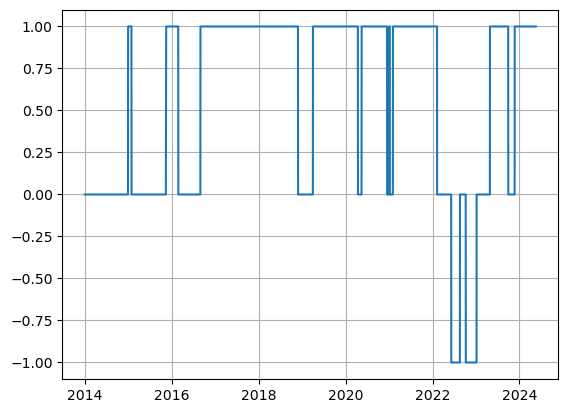

In [10]:
# 추세 신호 그래프
plt.plot(msft_df['regime'])
plt.grid(True)
plt.show()

매수 시 - 투자 수익률이 시장 수익률을 따라감
 - 시장이 올라야 내가 가진 자산가치가 증가할거니까

공매도 시 - 시장수익률을 반대로 따라감
 - 시장이 하락해야 내가 돈을 번다라고 예상

In [11]:
# 시장 수익률 계산
msft_df['Market'] = np.log(msft_df['Close']/msft_df['Close'].shift(1))

In [12]:
## 매매 전략
msft_df['Strategy'] = msft_df['regime'].shift(1)*msft_df['Market']

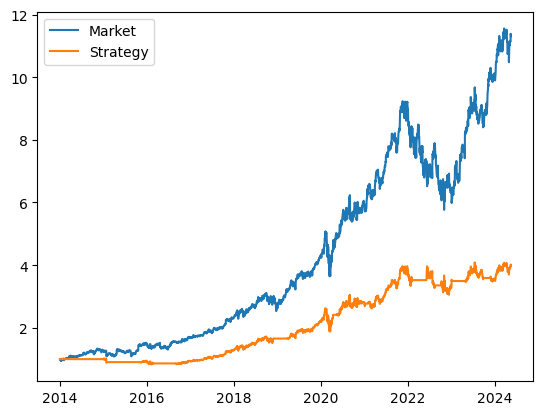

In [13]:
plt.plot(msft_df[['Market','Strategy']].cumsum().apply(np.exp))
plt.legend(['Market','Strategy'])
plt.show()

# 모형 결정

## 1st. 기하 브라운 운동 모형

#### 주식 종가 이녀석이 기하브라운 운동을 하는지 볼려면

1st. 로그 수익률이 정규분포를 따르고 있음? => 정규성 검정
 - 히스토그램으로 분포 확인
 -  qqplot 그려서 시각적으로 한 번 더 확인
 - 거기서 쫌 아리까리하면 왜도, 첨도 이용해서 카이제곱 검정
 - 한번더 해보려면 콜모고로프스미노프 검정 / 샤피로윌크 검정 으로 한 번 더 확인

2nd. 특정시간 t에서의 주가의 기대값은 지수함수 형태 => E(  S(t)  ) = S0 * exp( mu * t)  
 - 주가에 로그를 취한 값이 선형적인지 확인 => 선형회귀분석으로

3rd. 주가의 변동성은 시간에 따라 일정
 - 로그 수익률의 표준편차 구하고 Bartlett 검정

In [14]:
# 로그 수익률 계산
msft_df['log_ret'] = np.log( msft_df['Close'] / msft_df['Close'].shift(1) )

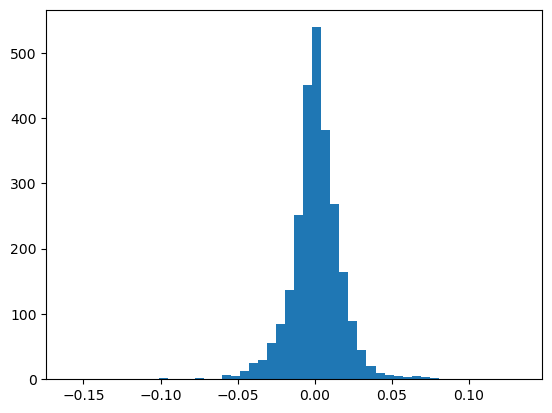

In [15]:
# 히스토그램으로 로그수익률 분포 확인
log_ret = msft_df['log_ret'].dropna()
plt.hist(log_ret,bins=50)
plt.show()

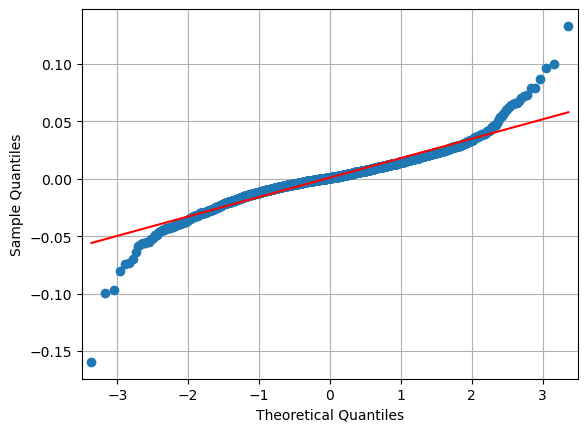

In [16]:
# qqplot 그려서 시각적으로 한 번 더 확인
sm.qqplot(log_ret,line='s')
plt.grid(True)
plt.show()

QQPLOT 보니까 

양 사이드가 삐죽 튀어나와있는 팻테일 현상이 일어났지 않습니까?

이러면 대부분 정규분포를 따르지 않을 가능성이 높습니다

수치적으로 한 번 더 확인해봅시다

In [17]:
# 왜도, 첨도 이용해서 정규성 검정
def norm_dist_test(a):
    skew = sc.skew(a)
    skew_pvalue = sc.skewtest(a)[1]
    kurt = sc.kurtosis(a)
    kurt_pvalue = sc.kurtosistest(a)[1]
    norm_pvalue = sc.normaltest(a)[1]

    print(f'왜도 : {skew : .2f}')
    print(f'왜도검정 p-value : {skew_pvalue*100 : .2f}')
    print(f'첨도 : {kurt : .2f}')
    print(f'첨도검정 p-value : {kurt_pvalue*100 : .2f}')
    print(f'정규성 검정 p-value : {norm_pvalue*100 : .2f}')

In [18]:
norm_dist_test(log_ret)

왜도 : -0.14
왜도검정 p-value :  0.28
첨도 :  8.12
첨도검정 p-value :  0.00
정규성 검정 p-value :  0.00


p-value들 전부 0나와서

귀무가설 H0 : 정규분포를 따른다 

이거 기각됩니다

## 결론적으로 기하브라운 운동 모형을 적용할 수 없다는 얘깁니다

In [19]:
## 잡설
## 로그 주가가선형적이긴 합니다
# a = np.log(msft_df['Close']) # 로그주가
# b = np.arange(len(a))
# c = stats.linregress(b, a)
# dep = c.intercept + c.slope * b
# print(f'로그주가 기울기 : {c.slope}')
# print(f'로그주가 상수항 : {c.slope}')
# print(f'로그주가 r-squared : {c.slope}')
# print(f'로그주가 p-value : {c.slope}')
# plt.plot(dep)
# plt.show()

# 근데 주가변동성은 시간에 따라 일정하진 않아요
# a = msft_df['Close'].rolling(window=42).std()
# plt.plot(a.dropna())

# 2.FGARCH 모형

In [20]:
a = np.log(msft_df['log_ret']).replace([np.inf, -np.inf], np.nan).dropna()
fgarch = arch_model(a, p=1, o=1, q=1, power=2, dist='t', vol='GARCH')
result_fgarch = fgarch.fit()
forecast_result = result_fgarch.forecast(horizon=5)
forecast_values = forecast_result.mean.iloc[-1].values
actual_value = a.iloc[-1]
actual_values = [actual_value] * 5
comparison = pd.DataFrame({'Actual': actual_values, 'Forecast': forecast_values})


Iteration:      1,   Func. Count:      8,   Neg. LLF: 123528.10953479976
Iteration:      2,   Func. Count:     18,   Neg. LLF: 25938.296196256713
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2189.9994116425482
Iteration:      4,   Func. Count:     35,   Neg. LLF: 3468.6182920162328
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2921.551185226427
Iteration:      6,   Func. Count:     51,   Neg. LLF: 2282.060744278679
Iteration:      7,   Func. Count:     59,   Neg. LLF: 2187.0785657369897
Iteration:      8,   Func. Count:     67,   Neg. LLF: 3476.0024733027094
Iteration:      9,   Func. Count:     76,   Neg. LLF: 3252.582070202964
Iteration:     10,   Func. Count:     84,   Neg. LLF: 2147.1380608048917
Iteration:     11,   Func. Count:     92,   Neg. LLF: 2146.783205191148
Iteration:     12,   Func. Count:     99,   Neg. LLF: 2146.848827792206
Iteration:     13,   Func. Count:    107,   Neg. LLF: 2146.763239762074
Iteration:     14,   Func. Count:    114,   Neg. LLF: 214

C:\Users\USER\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\USER\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
mse = mean_squared_error(actual_values, forecast_values) 
rmse = np.sqrt(mse)
print(f'RMSE: {rmse*100 : .2f}')


RMSE:  65.20


In [22]:
# 3. 점프확산모형
# 4. 제곱근확산모

## 이후 계획

 - FGARCH 모형에서 자기상관성, 추세성 파악 후 파라미터 재조정 GridSearchCV
 - QQQ 에 포함된 티커들 모형 적합
 - 